In [14]:
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import numpy as np

from sklearn.metrics import classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Dense,
    Flatten,
    Conv2D,
    MaxPooling2D,
    Dropout,
    BatchNormalization,
    Input,
    RandomFlip,
    RandomBrightness,
    RandomContrast,
    Rescaling,
    RandomRotation,
    RandomZoom
)
from tensorflow.keras.metrics import BinaryAccuracy
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [134]:
seed = 1000
batch_size = 64
img_size=224

In [135]:
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=18,
    titlepad=10,
)
plt.rc("image", cmap="magma")

# Dataset

A princípio, os dados serão separados apenas em treinamento e teste


In [136]:
X_train, X_test = image_dataset_from_directory(
    directory="./dataset",
    labels="inferred",
    label_mode="binary",
    color_mode="rgb",
    image_size=(img_size, img_size),
    batch_size=batch_size,
    shuffle=True,
    seed=seed,
    validation_split=0.2,
    subset="both",
    pad_to_aspect_ratio=False,
    verbose=True,
)

Found 923 files belonging to 2 classes.
Using 739 files for training.
Using 184 files for validation.


# Modelo


In [137]:
data_augmentation = Sequential([
	RandomFlip(mode="horizontal", seed=seed),
	RandomBrightness(factor=0.2, seed=seed),
	RandomContrast(factor=0.2, seed=seed)
])

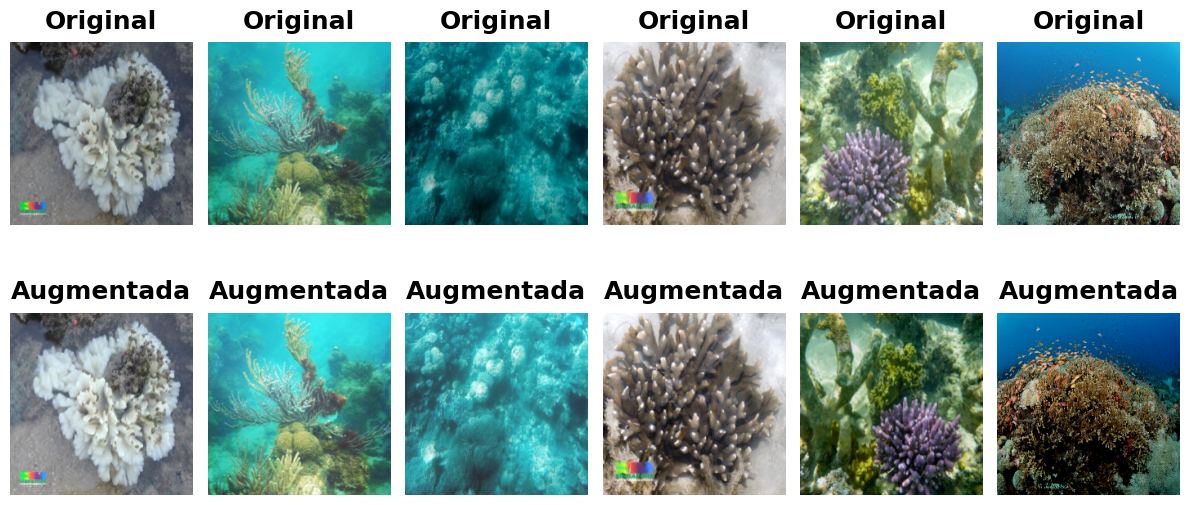

In [138]:
for images, labels in X_train.take(1):
    # Aplique o data augmentation
    augmented_images = data_augmentation(images)

    # Plote as imagens originais e aumentadas lado a lado
    plt.figure(figsize=(12, 6))
    for i in range(6):  # Mostra as 6 primeiras imagens do batch
        # Original
        plt.subplot(2, 6, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title("Original")
        plt.axis("off")
        
        # Augmentada
        plt.subplot(2, 6, i + 7)
        plt.imshow(augmented_images[i].numpy().astype("uint8"))
        plt.title("Augmentada")
        plt.axis("off")
    plt.tight_layout()
    plt.show()
    break  # Mostra só o primeiro batch

In [139]:
model = Sequential([
    Input(shape=(img_size, img_size, 3)),
	data_augmentation,
 	Rescaling(1./255),
    Conv2D(filters=32, kernel_size=(3, 3), activation="relu", kernel_initializer="he_normal", padding="same"),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(filters=32, kernel_size=(3, 3), activation="relu", kernel_initializer="he_normal", padding="same"),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(filters=64, kernel_size=(3, 3), activation="relu", kernel_initializer="he_normal", padding="same"),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(filters=128, kernel_size=(3, 3), activation="relu", kernel_initializer="he_normal", padding="same"),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(units=1024, activation="relu", kernel_initializer="he_normal"),
    Dropout(0.2),
    Dense(units=512, activation="relu", kernel_initializer="he_normal"),
    Dropout(0.2),
    Dense(units=128, activation="relu", kernel_initializer="he_normal"),
    Dense(units=1, activation="sigmoid")
])

model.compile(
    optimizer="adam", loss="binary_crossentropy", metrics=[BinaryAccuracy()]
)

model.summary()

Model: "sequential_25"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_24 (Sequential)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_7 (Rescaling)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 112, 112, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 112, 112, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 56, 56, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 56, 56, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 56, 56, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 28, 28, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1024)           │    25,691,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26,385,249 (100.65 MB)

 Trainable params: 26,384,737 (100.65 MB)

 Non-trainable params: 512 (2.00 KB)

CallBacks


In [140]:
es = EarlyStopping(
    monitor="val_binary_accuracy", patience=40, restore_best_weights=True, verbose=1
)

rlr = ReduceLROnPlateau(monitor="val_binary_accuracy", factor=0.2, patience=20, verbose=True)

In [141]:
history = model.fit(
    X_train,
    validation_data=X_test,
    epochs=200,
    callbacks=[es, rlr],
)

Epoch 1/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - binary_accuracy: 0.5345 - loss: 6.9173 - val_binary_accuracy: 0.4946 - val_loss: 7.3943 - learning_rate: 0.0010
Epoch 2/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - binary_accuracy: 0.6591 - loss: 1.4314 - val_binary_accuracy: 0.6739 - val_loss: 0.8242 - learning_rate: 0.0010
Epoch 3/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - binary_accuracy: 0.7034 - loss: 1.2302 - val_binary_accuracy: 0.4946 - val_loss: 6.7687 - learning_rate: 0.0010
Epoch 4/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - binary_accuracy: 0.7113 - loss: 1.0552 - val_binary_accuracy: 0.5217 - val_loss: 3.2252 - learning_rate: 0.0010
Epoch 5/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - binary_accuracy: 0.7096 - loss: 0.8724 - val_binary_accuracy: 0.5652 - val_loss: 1.3516 - learning_rate: 0.0010
Epoch 6/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - binary_accuracy: 0.7739 - loss: 0.6174 - val_binary_accuracy: 0.5109 - val_loss: 1.6177 - learning_rate: 0.0010
Epoch 7/20

# Resultados


In [142]:
y_pred = model.predict(X_test, batch_size=batch_size, verbose=1)
y_pred_bool = (y_pred > 0.5).astype(int)

y_test = np.concatenate([y for x, y in X_test], axis=0)

print(classification_report(y_test, y_pred_bool))

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 244ms/step
              precision    recall  f1-score   support

         0.0       0.75      0.85      0.80        91
         1.0       0.83      0.73      0.78        93

    accuracy                           0.79       184
   macro avg       0.79      0.79      0.79       184
weighted avg       0.79      0.79      0.79       184



<Axes: >

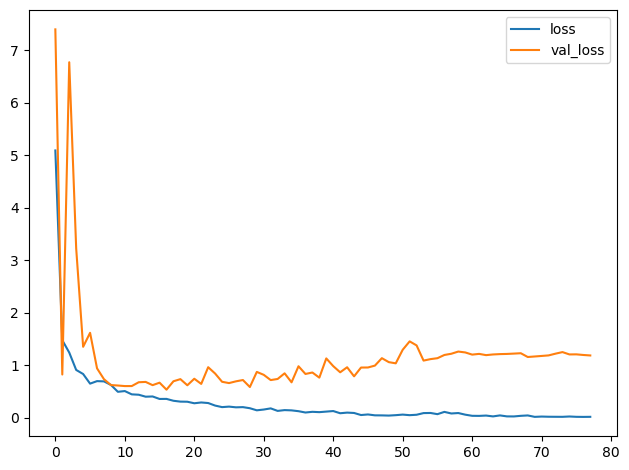

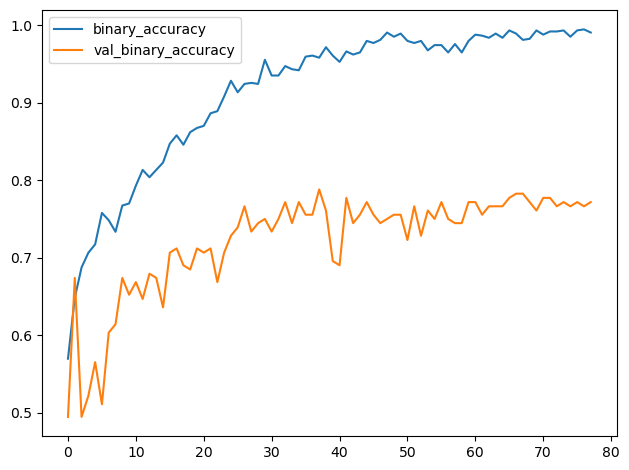

In [143]:
history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ["loss", "val_loss"]].plot()
history_frame.loc[:, ["binary_accuracy", "val_binary_accuracy"]].plot()